In [2]:
import os
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

from utils.conn_data import load_pickle

plt.style.use('ggplot')

In [3]:
models = [
    'spectrum',
    'sdne_20_1_1', 'sdne_30_1_1', 'sdne_40_1_1', 'sdne_50_1_1', 'sdne_100_1_1', 'sdne_100_5_5', 'sdne_100_10_10', 'sdne_100_15_15', 'sdne_100_20_20',
]
datasets = ['simulation1']
outputs_path = os.path.join(os.getcwd(), 'data', 'outputs')

## Check all Model Prediction Errors

In [4]:
prediction_error = []
for model in models:
    for ds in datasets:

        # load data
        data = load_pickle(os.path.join(outputs_path, ds, model, 'results.pkl'))

        try:
            pred_df = pd.DataFrame({"pred": data['pred'], "true": data["true"]}).dropna()
        except:
            pred_df = pd.DataFrame({"pred": data['test_pred'], "true": data["test_true"]}).dropna()

        # compute relevant metrics
        mse = mean_squared_error(pred_df['true'], pred_df['pred'])
        mae = mean_absolute_error(pred_df['true'], pred_df['pred'])

        # store results
        prediction_error.append({"model": model, "dataset": ds, "mse": mse, "mae": mae})

prediction_error_df = pd.DataFrame(prediction_error)

## MSE Comparison

In [5]:
prediction_error_df.sort_values(by=['mse'], ascending=True)

,model,dataset,mse,mae
6,sdne_100_5_5,simulation1,0.332558,0.499975
8,sdne_100_15_15,simulation1,0.334392,0.500206
3,sdne_40_1_1,simulation1,0.344615,0.505871
2,sdne_30_1_1,simulation1,0.344622,0.505862
7,sdne_100_10_10,simulation1,0.347191,0.507014
9,sdne_100_20_20,simulation1,0.362240,0.514483
4,sdne_50_1_1,simulation1,0.371009,0.518962
5,sdne_100_1_1,simulation1,0.386431,0.526388
1,sdne_20_1_1,simulation1,0.418977,0.541828
0,spectrum,simulation1,1.109323,0.858614


In [6]:
prediction_error_df.sort_values(by=['mse'], ascending=True)

,model,dataset,mse,mae
6,sdne_100_5_5,simulation1,0.332558,0.499975
8,sdne_100_15_15,simulation1,0.334392,0.500206
3,sdne_40_1_1,simulation1,0.344615,0.505871
2,sdne_30_1_1,simulation1,0.344622,0.505862
7,sdne_100_10_10,simulation1,0.347191,0.507014
9,sdne_100_20_20,simulation1,0.362240,0.514483
4,sdne_50_1_1,simulation1,0.371009,0.518962
5,sdne_100_1_1,simulation1,0.386431,0.526388
1,sdne_20_1_1,simulation1,0.418977,0.541828
0,spectrum,simulation1,1.109323,0.858614


## Check Individual Model

In [7]:
model = 'spectrum'
ds = 'simulation1'

# load data
data = load_pickle(os.path.join(outputs_path, ds, model, 'results.pkl'))
inputs = load_pickle(os.path.join(outputs_path, ds, model, 'inputs.pkl'))

try:
    # compute relevant metrics
    mse = mean_squared_error(data['true'], data['pred'])
    mae = mean_absolute_error(data['true'], data['pred'])

    # store results
    prediction_error.append({"model": model, "dataset": ds, "mse": mse, "mae": mae})
except:
    print(f'Error for {model} on {ds}')

pred_df = pd.DataFrame({'pred': data['pred'], 'true': data['true']})

# find nans
nan_rows = pred_df[pred_df.isnull().any(1)]

Error for spectrum on simulation1


In [8]:
nan_rows

,pred,true
684,NaN,-0.1
12994,NaN,0.2
15476,NaN,0.5
15526,NaN,-0.5
23251,NaN,-1.0
24185,NaN,-0.4


In [9]:
inputs["inputs"].shape

torch.Size([6, 2, 100, 100])

In [12]:
print(f"True covariance = {nan_rows.iloc[0]['true']}")

True covariance = -0.10000000149011612


In [19]:
adj1 = inputs["inputs"][0, 0, :, :]
adj2 = inputs["inputs"][0, 1, :, :]

<Axes: >

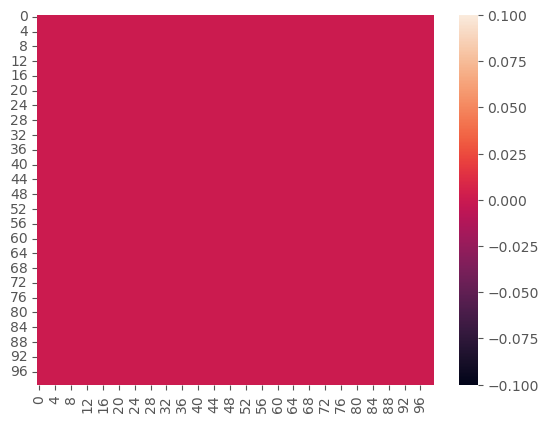

In [20]:
sns.heatmap(adj1)

<Axes: >

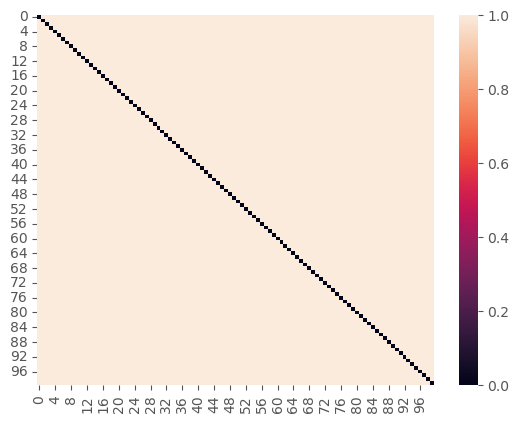

In [21]:
sns.heatmap(adj2)